<a href="https://colab.research.google.com/github/mahalakshmijinadoss/denoising_cifar10/blob/master/final_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU, Concatenate,Dropout,MaxPool2D,LeakyReLU,add
from keras.models import Model
from keras.datasets import cifar10
import numpy as np


In [38]:
#load the dataset
(x_train_clean, _), (x_test_clean, _) = cifar10.load_data()

In [39]:
#convert to floating point
x_train_clean = x_train_clean.astype('float32') / 255.
x_test_clean = x_test_clean.astype('float32') / 255.

In [40]:
#adding gaussian noise with mean=0 and std=0.1
def add_noise_and_clip(data):
    noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
    data = data + noise
    data = np.clip(data, 0., 1.)
    return data
#clipping values back to 0-1
x_train_noisy = add_noise_and_clip(x_train_clean)
x_test_noisy = add_noise_and_clip(x_test_clean)

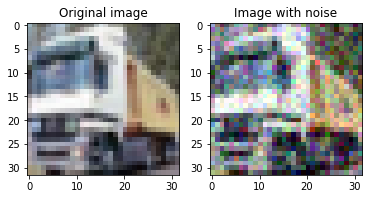

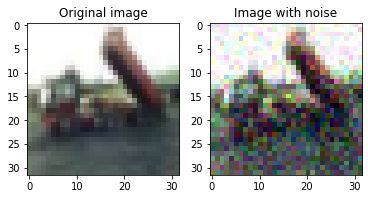

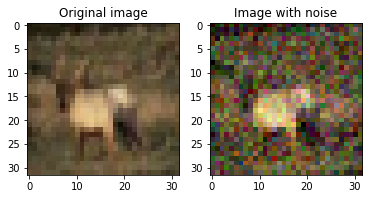

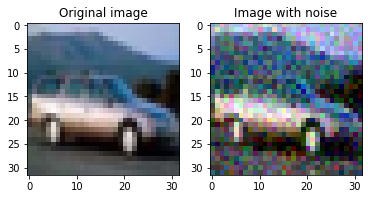

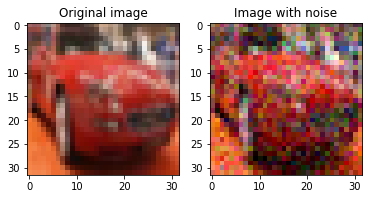

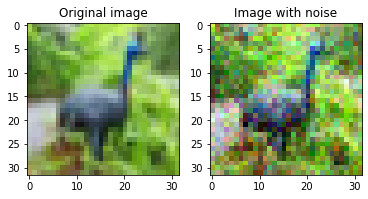

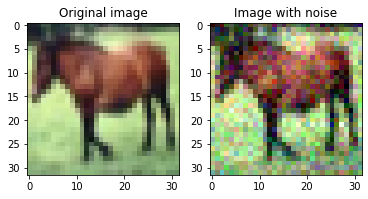

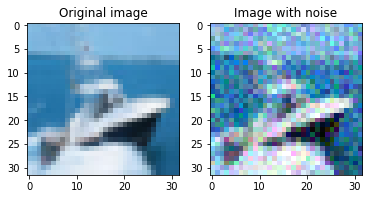

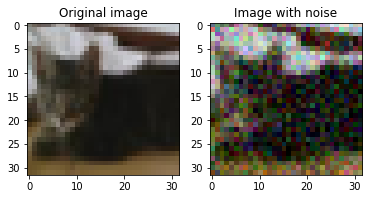

In [41]:
#display images before and after adding noise
for i in range(1,10):
  plt.subplot(1,2,1)
  plt.imshow(x_train_clean[i])
  plt.title('Original image')
  plt.subplot(1,2,2)
  plt.imshow(x_train_noisy[i])
  plt.title('Image with noise')
  plt.show()

In [42]:

from keras.optimizers import Adam

Model brief:

3 Conv2D layers followed by BatchNormalization , MaxPool2D

No dropout

Skip connection  to restore lost information during convolution and deconvolution.

Conv2DTranspose layer instead of Upscaling

In [43]:
# Encoder part
inputs = Input(shape=(32,32,3))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
x = ReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)

# Decoder part
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip]) # adding skip connection
x = ReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

model = Model(inputs, decoded)
model.compile(optimizer=Adam(lr=0.001), loss='mse',metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 32)   128         conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 16, 16, 32)   0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [44]:
# Training
history = model.fit(x_train_noisy,
        x_train_clean,
        validation_data=(x_test_noisy, x_test_clean),
        epochs=25,
        batch_size=128)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 17s 348us/step - loss: 0.0068 - accuracy: 0.6810 - val_loss: 0.0062 - val_accuracy: 0.7144
Epoch 2/25
50000/50000 [==============================] - 16s 320us/step - loss: 0.0029 - accuracy: 0.7552 - val_loss: 0.0027 - val_accuracy: 0.7498
Epoch 3/25
50000/50000 [==============================] - 16s 323us/step - loss: 0.0026 - accuracy: 0.7670 - val_loss: 0.0024 - val_accuracy: 0.7487
Epoch 4/25
50000/50000 [==============================] - 16s 320us/step - loss: 0.0024 - accuracy: 0.7735 - val_loss: 0.0023 - val_accuracy: 0.7588
Epoch 5/25
50000/50000 [==============================] - 16s 325us/step - loss: 0.0023 - accuracy: 0.7769 - val_loss: 0.0021 - val_accuracy: 0.7834
Epoch 6/25
50000/50000 [==============================] - 16s 322us/step - loss: 0.0022 - accuracy: 0.7801 - val_loss: 0.0021 - val_accuracy: 0.7654
Epoch 7/25
50000/50000 [==============================] 

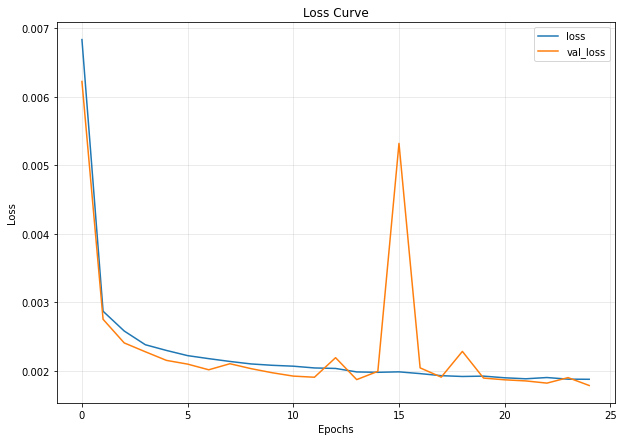

In [50]:
#loss plot
# Define Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Add Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training data
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation data

plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve.png")
plt.show()

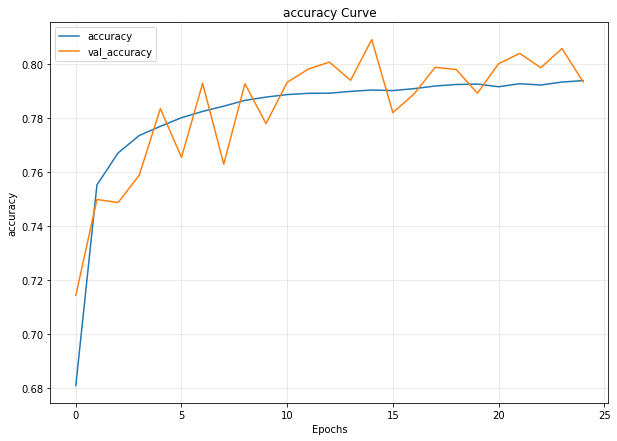

In [51]:
# accuracy plot
#Add figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Add Subplot
plt.plot(history.epoch, history.history['accuracy'], label = "accuracy") # Loss curve for training dataset
plt.plot(history.epoch, history.history['val_accuracy'], label = "val_accuracy") # Loss curve for validation dataset

plt.title("accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("acc_curve.png")
plt.show()

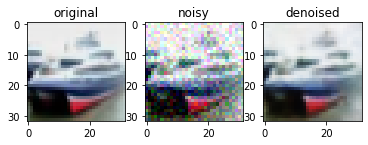

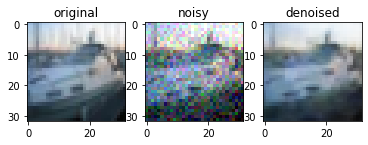

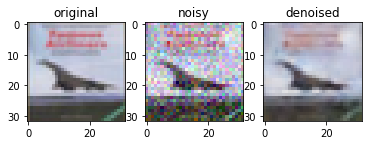

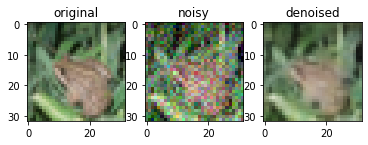

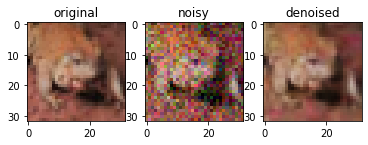

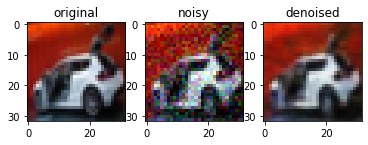

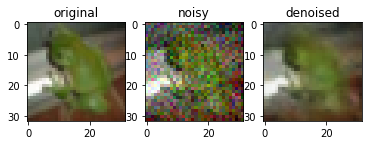

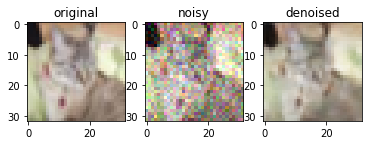

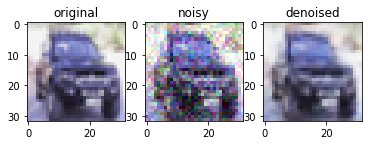

In [52]:
#print 10 original,noisy,denoised images
test_data_denoised = model.predict(x_test_noisy)
for i in range(1,10):
  plt.subplot(1,3,1)
  plt.imshow(x_test_clean[i])
  plt.title('original')
  plt.subplot(1,3,2)
  plt.imshow(x_test_noisy[i])
  plt.title('noisy')
  plt.subplot(1,3,3)
  plt.imshow(test_data_denoised[i])
  plt.title('denoised')
  plt.show()

In [53]:
#calculate mse for the whole CIFAR10 test set
def mse(data_1, data_2):
    return np.square(np.subtract(data_1, data_2)).mean()
noisy_clean_mse = mse(x_test_clean, x_test_noisy)
denoised_clean_mse = mse(test_data_denoised, x_test_clean)
noisy_clean_mse, denoised_clean_mse



(0.009305847470216027, 0.0017820715)

In [54]:
print("percentage by which noise is reduced equals",((noisy_clean_mse-denoised_clean_mse)/noisy_clean_mse)*100)

percentage by which noise is reduced equals 80.84998115903906
